In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

pd.set_option('display.width', None)

pd.set_option('display.max_colwidth', None)

In [2]:
all_players = nfl.import_players()
all_qbs = all_players[all_players['position'] == 'QB']
all_qbs.reset_index(inplace=True, drop='index')
all_qbs_id = list(all_qbs.gsis_id)

In [65]:
weekly_data = nfl.import_weekly_data(years=[i for i in range(1999,2025)])
weekly_data['completion_pct'] = weekly_data.completions / weekly_data.attempts
weekly_relevant = weekly_data[weekly_data['player_id'].isin(all_qbs_id)][['player_id', 'season', 'passing_tds', 'interceptions', 
                                                                          'sacks', 'sack_fumbles', 'rushing_tds', 
                                                                          'rushing_fumbles', 'completion_pct', 'passing_air_yards', 'attempts',
                                                                          'passing_yards', 'passing_epa', 'rushing_epa']]
weekly_relevant = weekly_relevant.groupby(['player_id', 'season']).agg({
    'passing_tds' : 'sum', 
    'interceptions' : 'sum',
    'sacks' : 'sum',
    'sack_fumbles' : 'sum',
    'rushing_tds' : 'sum',
    'rushing_fumbles' : 'sum', 
    'completion_pct' : 'mean',
    'passing_air_yards' : 'sum',
    'attempts' : 'sum',
    'player_id' : 'count',
    'passing_yards' : 'sum',
    'passing_epa' : 'sum',
    'rushing_epa' : 'sum'})

weekly_relevant = weekly_relevant.rename(columns={'player_id' : 'games_played'})
weekly_relevant = weekly_relevant[(weekly_relevant['attempts'] > 200) & (weekly_relevant['games_played'] > 8)]
weekly_relevant = weekly_relevant.reset_index()

Downcasting floats.


In [7]:
stats2024 = nfl.import_pbp_data(years=[i for i in range(1999,2025)])
stats2024 = stats2024[(stats2024['qb_kneel'] == 0.0) & (stats2024['play_type'] != 'no_play')]
relevant = stats2024[['play_type', 'shotgun', 'qb_dropback', 'qb_scramble', 'air_yards', 'rushing_yards', 'id', 'season', 'time_to_throw', 'air_epa']]

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [66]:
relevant = relevant.rename(columns={'id' : 'player_id'})
pass_stats = relevant[relevant['play_type'] == 'pass'].groupby(['player_id', 'season']).agg({'shotgun' : 'sum', 'qb_dropback' : 'sum', 'time_to_throw' : 'mean', 'air_epa' : 'sum'})
pass_stats['shotgun'] = pass_stats.shotgun / pass_stats.qb_dropback
pass_stats.columns = ['shotgun_rate', 'total_passes', 'avg_time_to_throw', 'air_epa']
pass_stats = pass_stats.reset_index()

In [67]:
pass_stats

,player_id,season,shotgun_rate,total_passes,avg_time_to_throw,air_epa
0,00-0000098,2000,0.000000,1.0,NaN,0.000000
1,00-0000104,1999,0.320988,486.0,NaN,0.000000
2,00-0000104,2000,0.003663,273.0,NaN,0.000000
3,00-0000108,2006,0.000000,1.0,NaN,-0.702337
4,00-0000108,2011,0.000000,1.0,NaN,2.770659
...,...,...,...,...,...,...
2787,00-0039890,2024,1.000000,1.0,NaN,-1.090507
2788,00-0039910,2024,0.962963,648.0,NaN,246.947754
2789,00-0039916,2024,0.000000,1.0,NaN,0.634156
2790,00-0039917,2024,0.944954,109.0,NaN,88.884308


In [68]:
run_stats = relevant[relevant['play_type'] == 'run'].groupby(['player_id', 'season']).agg({'qb_scramble' : ['sum', 'count'], 'rushing_yards' : 'sum'})
run_stats.columns = ['qb_scramble_sum', 'total_runs', 'rushing_yards']
run_stats['qb_scramble_rate'] = run_stats.qb_scramble_sum / run_stats.total_runs
run_stats = run_stats[['qb_scramble_rate', 'total_runs', 'rushing_yards']]
run_stats = run_stats.reset_index()
run_stats

,player_id,season,qb_scramble_rate,total_runs,rushing_yards
0,0,2000,0.000000,1,0.0
1,00-0000003,1999,0.006993,143,443.0
2,00-0000003,2000,0.000000,1,-2.0
3,00-0000007,1999,0.000000,5,12.0
4,00-0000007,2000,0.000000,16,70.0
...,...,...,...,...,...
8729,00-0039917,2024,0.800000,5,14.0
8730,00-0039918,2024,0.666667,75,495.0
8731,00-0039919,2024,0.000000,3,15.0
8732,00-0039920,2024,0.000000,2,26.0


In [69]:
total_data = weekly_relevant.merge(pass_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
total_data = total_data.merge(run_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
total_data.set_index(['player_id', 'season'])
#total_data = weekly_relevant.join(pass_stats).join(run_stats)

total_data['sacks_per_dropback'] = total_data['sacks'] / total_data['total_passes']
total_data['sack_fumbles'] = total_data['sack_fumbles'] / total_data['total_passes']

total_data['interceptions_per_game'] = total_data['interceptions'] / total_data['games_played']
total_data['passing_tds_per_game'] = total_data['passing_tds'] / total_data['games_played']
total_data['passing_air_yards_per_attempt'] = total_data['passing_air_yards'] / total_data['attempts']
total_data['passing_yards_per_game'] = total_data['passing_yards'] / total_data['games_played']

total_data['rushing_tds_per_game'] = total_data['rushing_tds'] / total_data['games_played']
total_data['rushing_fumbles_per_game'] = total_data['rushing_fumbles'] / total_data['games_played']
total_data['rushing_yards_per_game'] = total_data['rushing_yards'] / total_data['games_played']
total_data['rushing_yards_per_attempt'] = total_data['rushing_yards'] / total_data['total_runs']

total_data['pass_pct'] = total_data.total_passes / (total_data.total_passes + total_data.total_runs)

total_data['runs_per_game'] = total_data['total_runs'] / total_data['games_played']
total_data['attempts_per_game'] = total_data['attempts'] / total_data['games_played']

total_data['td:int'] = total_data['passing_tds'] / total_data['interceptions']
total_data['air_yard:completion_pct'] = total_data['passing_air_yards_per_attempt'] / total_data['completion_pct']

total_data = total_data[['player_id', 'season', 'sacks_per_dropback', 'attempts_per_game', 'rushing_tds_per_game', 'passing_tds_per_game', 'interceptions', 
                         'shotgun_rate', 'passing_air_yards_per_attempt', 'completion_pct',
                         'rushing_fumbles_per_game', 'rushing_yards_per_game', 'rushing_yards_per_attempt', 'pass_pct',
                         'air_yard:completion_pct', 'td:int']]

In [70]:
df = total_data.reset_index().merge(all_qbs[['gsis_id', 'display_name']], left_on='player_id', right_on='gsis_id')

qb_names = [(x['season'], x['display_name']) for idx, x in df.iterrows()]
qb_names

[(1999, 'Troy Aikman'),
 (2000, 'Troy Aikman'),
 (1999, 'Tony Banks'),
 (2000, 'Tony Banks'),
 (2001, 'Tony Banks'),
 (1999, 'Charlie Batch'),
 (2000, 'Charlie Batch'),
 (2001, 'Charlie Batch'),
 (1999, 'Steve Beuerlein'),
 (2000, 'Steve Beuerlein'),
 (1999, 'Jeff Blake'),
 (2000, 'Jeff Blake'),
 (2002, 'Jeff Blake'),
 (2003, 'Jeff Blake'),
 (1999, 'Drew Bledsoe'),
 (2000, 'Drew Bledsoe'),
 (2002, 'Drew Bledsoe'),
 (2003, 'Drew Bledsoe'),
 (2004, 'Drew Bledsoe'),
 (2005, 'Drew Bledsoe'),
 (2000, 'Aaron Brooks'),
 (2001, 'Aaron Brooks'),
 (2002, 'Aaron Brooks'),
 (2003, 'Aaron Brooks'),
 (2004, 'Aaron Brooks'),
 (2005, 'Aaron Brooks'),
 (1999, 'Mark Brunell'),
 (2000, 'Mark Brunell'),
 (2001, 'Mark Brunell'),
 (2002, 'Mark Brunell'),
 (2004, 'Mark Brunell'),
 (2005, 'Mark Brunell'),
 (2006, 'Mark Brunell'),
 (1999, 'Chris Chandler'),
 (2000, 'Chris Chandler'),
 (2001, 'Chris Chandler'),
 (1999, 'Kerry Collins'),
 (2000, 'Kerry Collins'),
 (2001, 'Kerry Collins'),
 (2002, 'Kerry Collins'

In [71]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
total_data = total_data.set_index('player_id')

In [72]:
total_data


,season,sacks_per_dropback,attempts_per_game,rushing_tds_per_game,passing_tds_per_game,interceptions,shotgun_rate,passing_air_yards_per_attempt,completion_pct,rushing_fumbles_per_game,rushing_yards_per_game,rushing_yards_per_attempt,pass_pct,air_yard:completion_pct,td:int
player_id,,,,,,,,,,,,,,,
00-0000104,1999,0.041152,31.066667,0.066667,1.133333,11.0,0.320988,0.000000,0.604938,0.133333,1.266667,1.583333,0.975904,0.000000,1.545455
00-0000104,2000,0.047619,23.545455,0.000000,0.636364,14.0,0.003663,0.000000,0.567402,0.000000,1.181818,1.300000,0.964664,0.000000,0.500000
00-0000722,1999,0.094017,28.909091,0.000000,1.454545,8.0,0.173789,0.000000,0.524115,0.181818,8.727273,4.571429,0.943548,0.000000,2.000000
00-0000722,2000,0.067797,19.642857,0.000000,0.571429,8.0,0.179661,0.000000,0.419681,0.071429,4.000000,2.947368,0.939490,0.000000,1.000000
00-0000722,2001,0.072319,24.666667,0.133333,0.666667,10.0,0.256858,0.000000,0.536239,0.533333,10.133333,3.234043,0.895089,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00-0039164,2024,0.050542,24.000000,0.545455,0.727273,12.0,0.960289,12.212121,0.508737,0.545455,46.181818,6.350000,0.775910,24.004784,0.666667
00-0039732,2024,0.042276,32.722222,0.222222,1.666667,12.0,0.856911,7.429542,0.659797,0.055556,27.277778,6.061728,0.883621,11.260352,2.500000
00-0039851,2024,0.090909,26.000000,0.153846,1.153846,10.0,0.882353,7.316568,0.595147,0.307692,32.538462,8.134615,0.877934,12.293706,1.500000


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(total_data)
for P in range(1, 10):
    pca = PCA(n_components=P)
    pca.fit(X)
    print(pca.explained_variance_ratio_.sum())


0.27953379935554684
0.5080615485768987
0.6251691230298624
0.7201410061682983
0.7859464413885149
0.8346415946896791
0.8800501275064959
0.9126245292236093
0.9407883118547861


In [ ]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

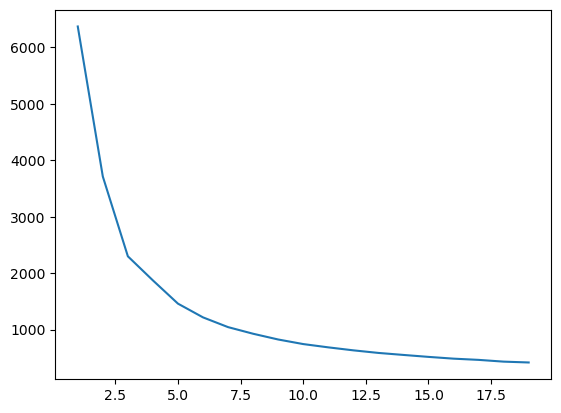

In [117]:
import plotly.express as px
intertia = []
for K in range(1,20):
    kmeans = KMeans(n_clusters=K)
    intertia.append(kmeans.fit(X= X_pca).inertia_)

kmeans = KMeans(n_clusters=5)
groups = kmeans.fit_predict(X=X_pca)
    
plt.plot(range(1,20), intertia)
plt.show()
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:,1], color=groups, hover_name=qb_names)
fig.show()

In [127]:
tier_list = weekly_relevant.merge(pass_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
tier_list = tier_list.merge(run_stats, left_on=['player_id', 'season'], right_on=['player_id', 'season'])
df = tier_list.reset_index().merge(all_qbs[['gsis_id', 'display_name']], left_on='player_id', right_on='gsis_id')
qb_names = [(f"{x['display_name']} {x['season']}") for idx, x in df.iterrows()]
qb_names
tier_list['tds_per_game'] = (tier_list['passing_tds'] + tier_list['rushing_tds']) / tier_list['games_played']
tier_list['yards_per_game'] = (tier_list['passing_yards'] + tier_list['rushing_yards'])/ tier_list['games_played']
tier_list['passing_yards_per_attempt'] = tier_list['passing_yards'] / tier_list['attempts']
tier_list['rushing_yards_per_run']  = tier_list['rushing_yards'] / tier_list['total_runs']
tier_list['turnovers_per_game'] = (tier_list['interceptions'] + tier_list['sack_fumbles'] + tier_list['rushing_fumbles']) / tier_list['games_played']
tier_list['td:turnover'] = tier_list['tds_per_game'] / tier_list['turnovers_per_game']
tier_list['passing_epa_per_game'] = tier_list['passing_epa'] / tier_list['games_played']
tier_list['rushing_epa_per_game'] = tier_list['rushing_epa'] / tier_list['games_played']


tier_list = tier_list[['tds_per_game', 'yards_per_game', 'passing_yards_per_attempt', 'rushing_yards_per_run', 
                       'turnovers_per_game', 'td:turnover', 'completion_pct', 'passing_epa_per_game', 'rushing_epa_per_game']]

In [128]:
tiered_pca = PCA(n_components=1)
scaler = StandardScaler()
X = scaler.fit_transform(tier_list)
ranks = tiered_pca.fit_transform(X)
ranked_df = pd.DataFrame(data=[qb_names, ranks]).T.reset_index(drop='index').set_index(0)
ranked_df.columns = ['scores']
ranked_df['scores'] = ranked_df['scores'].apply(lambda x : x[0])
ranked_df = ranked_df.sort_values('scores').reset_index()

In [129]:
ranked_df.columns = ('Names', 'Scores')
ranked_df

,Names,Scores
0,Akili Smith 2000,-5.929742
1,JaMarcus Russell 2009,-5.724111
2,Jimmy Clausen 2010,-5.555063
3,Andrew Walter 2006,-5.326875
4,Donovan McNabb 1999,-5.179581
...,...,...
831,Peyton Manning 2004,5.571231
832,Matt Ryan 2016,5.966620
833,Drew Brees 2011,6.167853
834,Aaron Rodgers 2011,6.872441


In [131]:
ranked_df = ranked_df.sort_values(by='Scores')
fig = px.bar(data_frame=ranked_df, x=ranked_df.Names, y=ranked_df.Scores)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [136]:
ranked_df.sort_values(by='Scores', ascending=False).head(10)

,Names,Scores
835,Aaron Rodgers 2020,6.966155
834,Aaron Rodgers 2011,6.872441
833,Drew Brees 2011,6.167853
832,Matt Ryan 2016,5.966620
831,Peyton Manning 2004,5.571231
830,Tom Brady 2007,5.511696
829,Patrick Mahomes 2018,5.281755
828,Drew Brees 2019,5.215108
827,Lamar Jackson 2024,5.186852
826,Aaron Rodgers 2021,5.137204


In [137]:
ranked_df.sort_values(by='Scores', ascending=True).head(10)

,Names,Scores
0,Akili Smith 2000,-5.929742
1,JaMarcus Russell 2009,-5.724111
2,Jimmy Clausen 2010,-5.555063
3,Andrew Walter 2006,-5.326875
4,Donovan McNabb 1999,-5.179581
5,Kyle Orton 2005,-5.053208
6,Mark Brunell 2004,-4.963757
7,Ryan Leaf 2000,-4.718951
8,David Carr 2002,-4.542388
9,Doug Pederson 1999,-4.536701


In [156]:
pca_com = tiered_pca.components_[0]
" + ".join([f"({pca_com[i]} x {tier_list.columns[i]})"  for i in range(len(pca_com))])

'(0.4120634649151468 x tds_per_game) + (0.3842366232514156 x yards_per_game) + (0.38828090812189764 x passing_yards_per_attempt) + (0.05884966120517504 x rushing_yards_per_run) + (-0.2317954047577885 x turnovers_per_game) + (0.39920983716438196 x td:turnover) + (0.3546404510366818 x completion_pct) + (0.4237529340875973 x passing_epa_per_game) + (0.09953175163512724 x rushing_epa_per_game)'